# Исследование трендов российского кинопроката

Нужно изучить рынок российского кинопроката и выявить текущие тренды.

Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

## Описание данных:
У одного фильма может быть несколько прокатных удостоверений. 
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.
- `puNumber` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

Столбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. 

In [6]:
!python -m pip install Levenshtein

In [7]:
import pandas as pd
import numpy as np
import seaborn as sb
from Levenshtein import distance
from matplotlib import pyplot as plt
from datetime import datetime as dt

### Откроем файл с данными и изучим общую информацию

In [8]:
try:
    df1 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_movies.csv")
    df2 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_shows.csv")
except:
    df1 = pd.read_csv("/datasets/mkrf_movies.csv")
    df2 = pd.read_csv("/datasets/mkrf_shows.csv")

pd.set_option('display.max_columns', None)
print(df1.head(20))
print(df2.head(20))


                                                title   puNumber  \
0                                    Открытый простор  221048915   
1                                Особо важное задание  111013716   
2                                        Особо опасен  221038416   
3                                        Особо опасен  221026916   
4                                        Особо опасен  221030815   
5                                   Остановился поезд  111013816   
6                                     Любовь и голуби  111007013   
7                                   Любовь и сигареты  221074614   
8                                  Отпетые мошенники.  121011416   
9                                 Отпуск за свой счет  111019114   
10  Превосходство Борна /По одноименной новелле Ро...  221031416   
11                                       Ответный ход  111019014   
12  Малышка на миллион /По мотивам рассказов Ф.Х.Т...  221011415   
13                                 Преданный сад

Преобразуем колонки к соответствующим типам данных.

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Поле `puNumber` содержит недопустимые для целочисленного типа значения. Точно так же поле `ratings` содержит недопустимые для вещественного типа значения. Преобразуем эти колонки к соответствующим типам через to_numeric() и оптимизируем типы для имеемых значений этих полей.

In [10]:
df1["puNumber"] = pd.to_numeric(df1["puNumber"], errors="coerce", downcast="integer")
df1["ratings"] = pd.to_numeric(df1["ratings"], errors="coerce", downcast="float")

In [11]:
df1 = df1.astype({"puNumber" : "UInt32", "show_start_date" : "datetime64"})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Также оптимизируем типы для полей `refundable_support`, `nonrefundable_support` и `budget`.

In [12]:
df1["refundable_support"] = pd.to_numeric(df1["refundable_support"], errors="coerce", downcast="unsigned")
df1["nonrefundable_support"] = pd.to_numeric(df1["nonrefundable_support"], errors="coerce", downcast="unsigned")
df1["budget"] = pd.to_numeric(df1["budget"], errors="coerce", downcast="unsigned")

Заметим, что поле `age_restriction` можно преобразовать к беззнаковому целыму типу. Преобразуем это поле. 

In [13]:
df1["age_restriction"] = pd.to_numeric(df1["age_restriction"].str.extract(r"(«\d*\+»)")[0].str.strip("«+»"), errors="coerce", downcast="unsigned")

Оптимизируем все строковые поля с уникальностью значений ниже 50%.

In [14]:
columns = df1.select_dtypes(include=['object'])

for col in columns:
    num_unique_values = len(df1[col].unique())
    num_total_values = len(df1[col])
    uniquness = num_unique_values / num_total_values

    print(col, f"uniquness is {uniquness * 100:.2f}%")

    if uniquness < 0.5:
        df1.loc[:,col] = df1[col].astype('category')
    else:
        df1.loc[:,col] = df1[col]

title uniquness is 90.46%
type uniquness is 0.08%
film_studio uniquness is 73.26%
production_country uniquness is 12.49%
director uniquness is 64.15%
producer uniquness is 71.39%
financing_source uniquness is 0.05%
genres uniquness is 9.93%


Проверим результат.

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   category      
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   category      
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   uint8         
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    category      
 13  rat

Так же преобразуем типы во втором датасете.

In [16]:
df2 = df2.astype({"puNumber" : "UInt32"})

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   UInt32 
 1   box_office  3158 non-null   float64
dtypes: UInt32(1), float64(1)
memory usage: 40.2 KB


Объединим эти данные в один DataFrame через left join df1 к df2 т.к. во втором содежжится только часть записей первого.

In [18]:
df = df1.merge(df2, on='puNumber', how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   category      
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   category      
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   uint8         
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    category      
 13  rat

### Обработаем пропуски

In [19]:
df.isna().sum()

title                       0
puNumber                    1
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

Посмотрим на фильм без номера прокатного удостоверения `puNumber` чтобы принять решение о полезности этой записи.

In [20]:
df[df["puNumber"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1797,Курбан-роман. (История с жертвой),<NA>,2014-05-15 12:00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку эта запись не содержит полезной для целий аналитики данных, избавимся от неё.

In [21]:
df = df[df["puNumber"].notna()]

Пропуски в поле со студией-производителем `film_studio` фильма не влияют на цели анализа и не могут быть алгоритмически заполнены, поэтому оставим их.

Рассмотрим филтмы с пропуском в стране производства `production_country`.

In [22]:
df[df["production_country"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",0,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [23]:
df["production_country"].unique()

['США', 'СССР', 'Франция', 'СССР, Венгрия', 'Германия-Великобритания', ..., 'КНР - Франция', 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]
Length: 935
Categories (934, object): ['США', 'СССР', 'Франция', 'СССР, Венгрия', ..., 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]

Заполним пропуски вручную т.к. понятно, что страна производства этих фильмов - РФ.

In [24]:
df.loc[df["production_country"].isna(), "production_country"] = "Россия"

Заполним пропуски в поле `director` вручную воспользовавшись поиском.

In [25]:
df[df["director"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,0,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,0,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,0,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


Поиск информации о режессёрах этих фильмов не дал результатов, поэтому оставим пропуски как есть.

Оставшиеся поля с пропусками не подлехат алгоритмическому заполнению. В случае с рейтингами или жанрами фильмов, их просто нет на площадке. Отсутствующая информация о финансировании означает, что проект не субсидировался.

### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [26]:
df.duplicated().sum()

0

In [27]:
df.duplicated(["title", "puNumber"]).sum()

0

Удалим дубликаты, которые отличаются случайными символами.

In [28]:
df["title"] = df["title"].str.strip("._- ")
df["title"] = df["title"].str.replace('ё', 'e')
df["title"] = df["title"].str.lower()

In [29]:
df = df.drop_duplicates(["title", "puNumber"])

Воспользуемся расстоянием Левенштайна между строками чтобы найти неявные дубликаты т.к. уникальных значений достаточно много чтобы обрабатывать их вручную и достаочно мало, чтобы алгоритм сработал за относительно непродолжительное время. 

In [30]:
def print_duplicates(strings, dist):
    duplicates_count = 0

    for i in range(0, len(strings)):
        for j in range(i, len(strings)):
            if i == j: continue

            if distance(strings.iloc[i], strings.iloc[j]) <= dist:
                print(f"{i}: {strings.iloc[i]} \t{j}: {strings.iloc[j]}")
                duplicates_count += 1
            
    print(f"Duplicates count: {duplicates_count}")

Исследуем названия фильмов с одним отличием.

In [32]:
print_duplicates(df["title"], 1)

2: особо опасен 	3: особо опасен
2: особо опасен 	4: особо опасен
3: особо опасен 	4: особо опасен
12: малышка на миллион /по мотивам рассказов ф.х.тула из сборника "клейма от канатов"/ 	4606: малышка на миллион /по мотивам рассказов ф.х.тула из сборника "клейма от канатов"/


KeyboardInterrupt: 

Проверим по индексам похожие на неявные дубликаты записи.

In [33]:
df.iloc[[738, 2053, 762, 1360, 937, 3560, 1581, 4427, 1737, 2467, 2375, 3983, 2392, 5727, 2448, 4176, 2838, 2866, 2866, 4735, 3203, 3918, 3940, 6380, 4076, 4429, 5894, 5957]]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
738,обливион,121004513,2013-02-21 12:00:00,Художественный,"Чернин Интертейнмент, Айрохед Студиос, Радикал...",США,Джозеф Косински,"Дилан Кларк, Джозеф Косински, Дункан Хендерсон",12,NaN,NaN,NaN,NaN,7.2,"фантастика,боевик,триллер",300.00
2054,мать мария,111025314,2014-12-24 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,С.Колосов,NaN,12,NaN,NaN,NaN,NaN,6.6,"драма,биография",NaN
762,вишенка на новогоднем торте,121030512,2012-12-17 12:00:00,Художественный,"Мэзон до Синема, Судэн Компани, Нат/Болт Прода...",Франция,Лаура Моранте,"Франческо Джиамматтео, Бруно Песери",16,NaN,NaN,NaN,NaN,5.8,комедия,NaN
1360,жорж бизе. кармен /по мотивам одноименной нове...,126003113,2013-09-03 12:00:00,Прочие,Синема Лайв,Австралия,"Брайан Томсон, Гейл Эдвардс",NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,волшебная страна,124001113,2013-04-15 12:00:00,Анимационный,"Брейктру Филмз, Эс Эм Бэ Инвестментс",Великобритания - Польша - КНР - Индия - Норвегия,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси","Магдалена Баргел, Хью Велчман",18,NaN,NaN,NaN,NaN,7.9,"драма,семейный,биография",20260.00
3561,поезд в пусан,121030816,2016-11-17 12:00:00,Художественный,Контентс Панда,Южная Корея,Ён Сан-хо,"Ли Дон-ха, Ким Ён-хо",18,NaN,NaN,NaN,NaN,7.1,"ужасы,боевик,триллер",8459304.83
1581,другая женщина,121006814,2014-04-09 12:00:00,Художественный,"Эл Би И Продакшнз, ХХ век Фокс",США,Ник Кассаветис,"Дональд Дж.Ли младший, Чак Пачеко, Джули Силве...",16,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN
4428,гарри поттер и принц-полукровка /по роману дж....,221134610,2010-11-29 12:00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,Дэйвид Хейман,12,NaN,NaN,NaN,NaN,7.7,"фэнтези,приключения,семейный",NaN
1737,как поймать перо жар-птицы,114000513,2013-10-11 12:00:00,Художественный,"ООО ""Визарт Фильм"", ООО ""Кинокомпания ""СТВ""",Россия,"В.Плотников, Г.Гитис","С.Сельянов, А.Лигай, С.Рапопорт, Ю.Москвин",0,NaN,NaN,NaN,NaN,5.2,"мультфильм,фэнтези",96846.00
2468,весь этот джем,111016515,2015-09-17 12:00:00,Художественный,"ООО ""Кинокомпания ""Спутник""",Россия,А.Адраникян,"А.Адраникян, В.Горяинов",16,NaN,NaN,NaN,NaN,5.0,"мелодрама,комедия",NaN


На основании ручного анализа схожих записей удалим неявные дубликаты. 

In [34]:
df = df.loc[df.index.drop([2745, 4698, 3194, 4366, 5068])]

In [35]:
df.duplicated(["title", "puNumber"]).sum()

0

Изучим категориальные поля. Удалим лишние символы в начале и конце всех строк с категориальными значениями.

In [36]:
df["type"] = df["type"].str.strip('._- ')
df["type"].value_counts()

Художественный                5903
Анимационный                   829
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

In [37]:
df["film_studio"] = df["film_studio"].str.strip('._- ')
df["film_studio"].value_counts()

Киностудия "Мосфильм"                                                           345
ООО "Мульт в кино"                                                               75
Анимаккорд Лтд                                                                   27
ООО "ТаББаК"                                                                     18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                           16
                                                                               ... 
ООО "СКАРАБЕЙ-фильм", ООО "Слава - синема", ООО "ТаББаК"                          1
ООО "Лаборатория кино"                                                            1
Энджел Филмз, Гранье Филм Би Ви, Эпидемик                                         1
Си Оу Ти Эй Филмз, Экоу Филмз                                                     1
Уайлд Банч, БиБиСи Филмз, БиФиАй Филм Фанд, Сикстин Филмз, Уай Нот Продакшнз      1
Name: film_studio, Length: 5458, dtype: int64

In [38]:
df["film_studio"] = df["film_studio"].str.strip('._- ')
df["film_studio"].value_counts()

Киностудия "Мосфильм"                                                           345
ООО "Мульт в кино"                                                               75
Анимаккорд Лтд                                                                   27
ООО "ТаББаК"                                                                     18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                           16
                                                                               ... 
ООО "СКАРАБЕЙ-фильм", ООО "Слава - синема", ООО "ТаББаК"                          1
ООО "Лаборатория кино"                                                            1
Энджел Филмз, Гранье Филм Би Ви, Эпидемик                                         1
Си Оу Ти Эй Филмз, Экоу Филмз                                                     1
Уайлд Банч, БиБиСи Филмз, БиФиАй Филм Фанд, Сикстин Филмз, Уай Нот Продакшнз      1
Name: film_studio, Length: 5458, dtype: int64

In [39]:
df["production_country"] = df["production_country"].str.strip('._- ')
df["production_country"].value_counts()

США                                                    2172
Россия                                                 1822
СССР                                                    377
Франция                                                 301
Великобритания                                          259
                                                       ... 
Россия-Польша-Голландия-Словакия                          1
США - Великобритания - Канада - КНР                       1
Дания - Германия - Швеция                                 1
Франция - Португалия                                      1
Великобритания - Гонконг - Венгрия - США - Ирландия       1
Name: production_country, Length: 933, dtype: int64

In [40]:
df["director"] = df["director"].str.strip('._- ')
df["director"].value_counts()

О.Семёнова            60
Стивен Содерберг      17
Д.Червяцов            17
Ридли Скотт           16
Тиль Швайгер          14
                      ..
Даниэль Фергюсон       1
М.Зыков, Ф.Абрютин     1
Лиэнн Пули             1
Пон Чжун-хо            1
Хи Зили                1
Name: director, Length: 4798, dtype: int64

In [41]:
df["producer"] = df["producer"].str.strip('._- ')
df["producer"].value_counts()

П.Смирнов                                                                                    67
Олег Кузовков, Дмитрий Ловейко, Марина Ратина                                                28
С.Сельянов                                                                                   18
Д.Ловейко, О.Кузовков                                                                        17
А.Тельнов                                                                                    12
                                                                                             ..
Джон Лешер, Брайан Оливер                                                                     1
А.Златопольский, Р.Дишдишян, Л.Блаватник, Н.Яралова при участии Л.Верещагина, Н.Михалкова     1
Королевская опера Валонии                                                                     1
Дэвид Бурла, Брюс Дэвей, Уильям Чэн                                                           1
Катрин Баикозис, Ян Дресслер, Давид Кайч

In [42]:
df["genres"] = df["genres"].str.strip('._- ')
df["genres"].value_counts()

драма                         476
комедия                       352
мелодрама,комедия             222
драма,мелодрама,комедия       189
драма,мелодрама               183
                             ... 
вестерн,биография,драма         1
драма,вестерн,боевик            1
мультфильм,фэнтези,триллер      1
криминал,комедия                1
история,драма,мелодрама         1
Name: genres, Length: 742, dtype: int64

Обновим индекс после чистки данных.

In [52]:
df = df.reset_index(drop=True)

Изучим столбцы с количественными значениями.

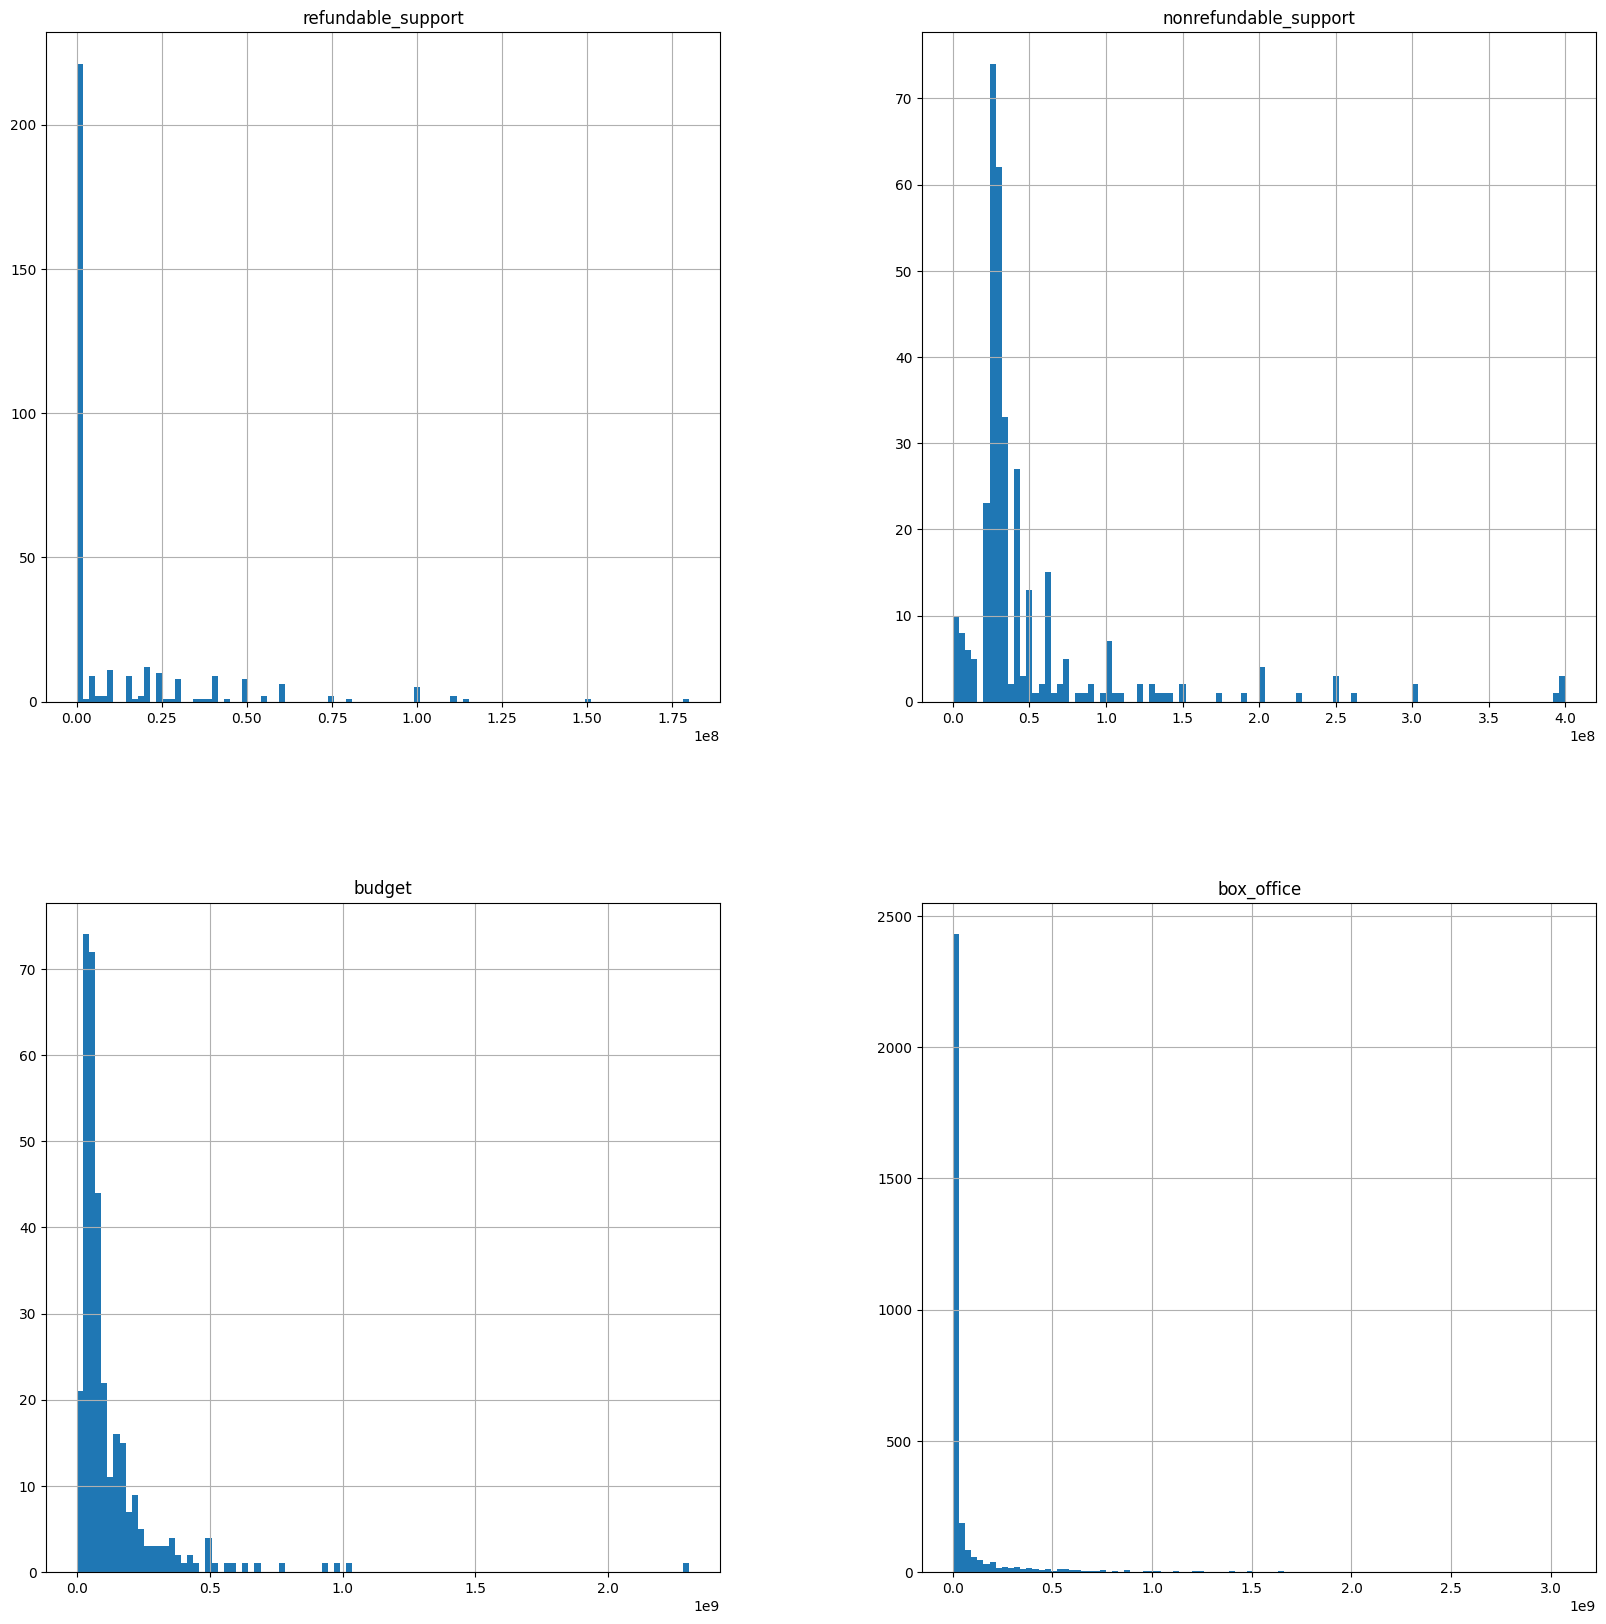

In [57]:
numeric = df.select_dtypes(include=['float', 'int'])
numeric.hist(bins=100, figsize=(20, 20));

Явно видно что бюджеты суюсидий большинства фильмов совредоточены в достаточно узком диапазоне. Рассмотрим каждое из полей подробнее используя wiskers.

refundable_support


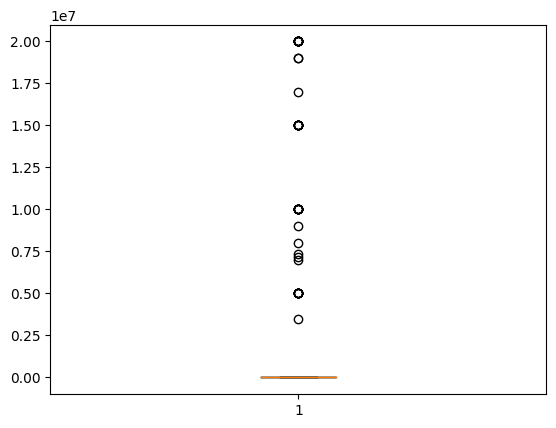

nonrefundable_support


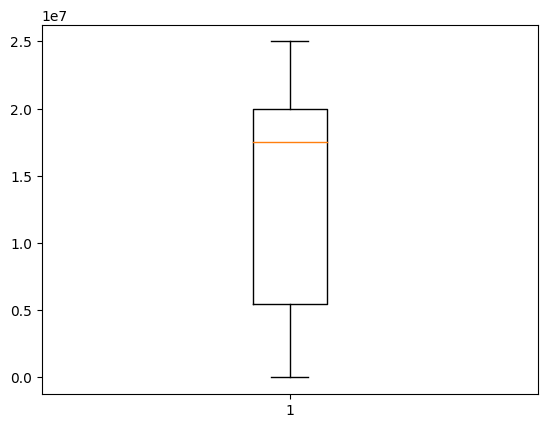

budget


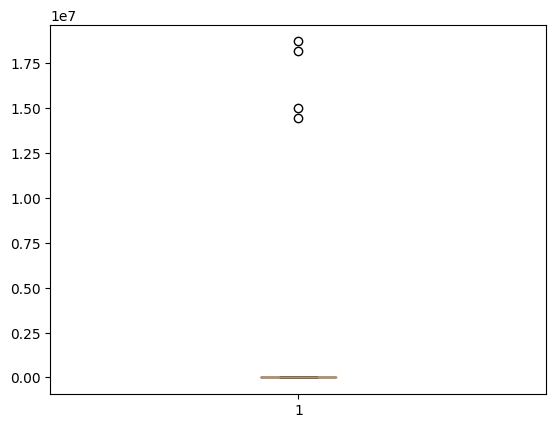

box_office


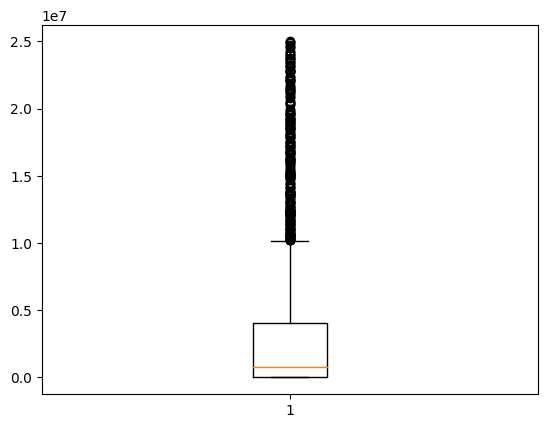

In [74]:
for col in numeric.columns:
    print(col)
    plt.boxplot(df.loc[(df[col].notna()) & (df[col] < 25_000_000), col]);
    plt.show()

Заметим, что проекты с безвозмездной поддержкой получают большие, чем остальные, субсидии. Отмасштабируем остальные финансовые поля.

In [75]:
numeric.columns

Index(['refundable_support', 'nonrefundable_support', 'budget', 'box_office'], dtype='object')

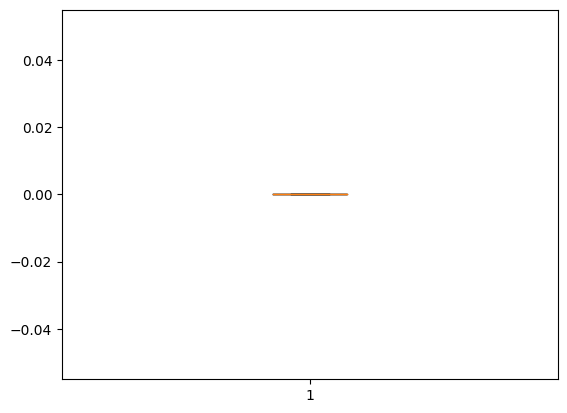

In [77]:
plt.boxplot(df.loc[(df["refundable_support"].notna()) & (df["refundable_support"] < 1_00_000), "refundable_support"]);

Кажется, что данные искажены нулевыми значениями. Проверим описательную статистику.

In [83]:
for col in numeric.columns:
    print(df[col].describe(), '\n')

count    3.320000e+02
mean     1.186446e+07
std      2.491656e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.500000e+07
max      1.800000e+08
Name: refundable_support, dtype: float64 

count    3.320000e+02
mean     4.898099e+07
std      5.998012e+07
min      0.000000e+00
25%      2.500000e+07
50%      3.000000e+07
75%      4.037500e+07
max      4.000000e+08
Name: nonrefundable_support, dtype: float64 

count    3.320000e+02
mean     1.272297e+08
std      1.885883e+08
min      0.000000e+00
25%      4.200000e+07
50%      6.864992e+07
75%      1.419853e+08
max      2.305074e+09
Name: budget, dtype: float64 

count    3.157000e+03
mean     7.650292e+07
std      2.403873e+08
min      0.000000e+00
25%      8.638600e+04
50%      2.330104e+06
75%      2.398312e+07
max      3.073569e+09
Name: box_office, dtype: float64 



Заменим на None нулевые значения, чтобы анализировать только субсидируемые картины. 

In [84]:
for col in numeric.columns:
    df[col] = df[col].replace(0, np.nan)

Рассмотрим графики ещё раз после замены.

refundable_support


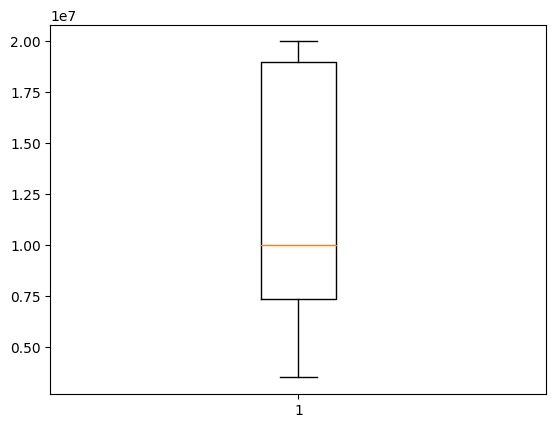

nonrefundable_support


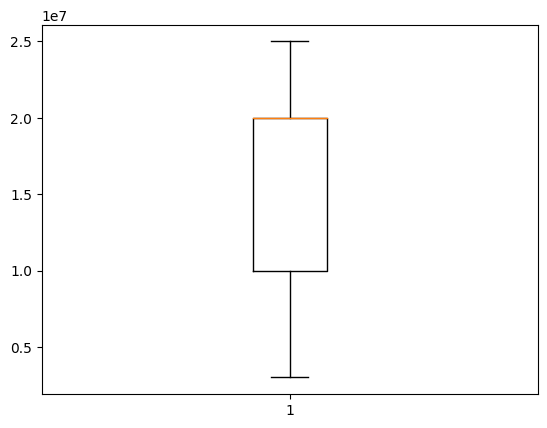

budget


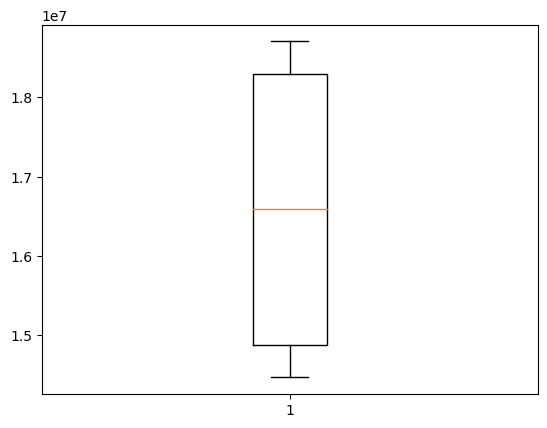

box_office


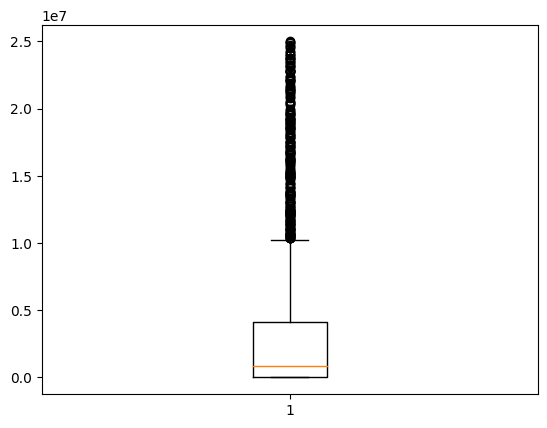

In [85]:
for col in numeric.columns:
    print(col)
    plt.boxplot(df.loc[(df[col].notna()) & (df[col] < 25_000_000), col]);
    plt.show()

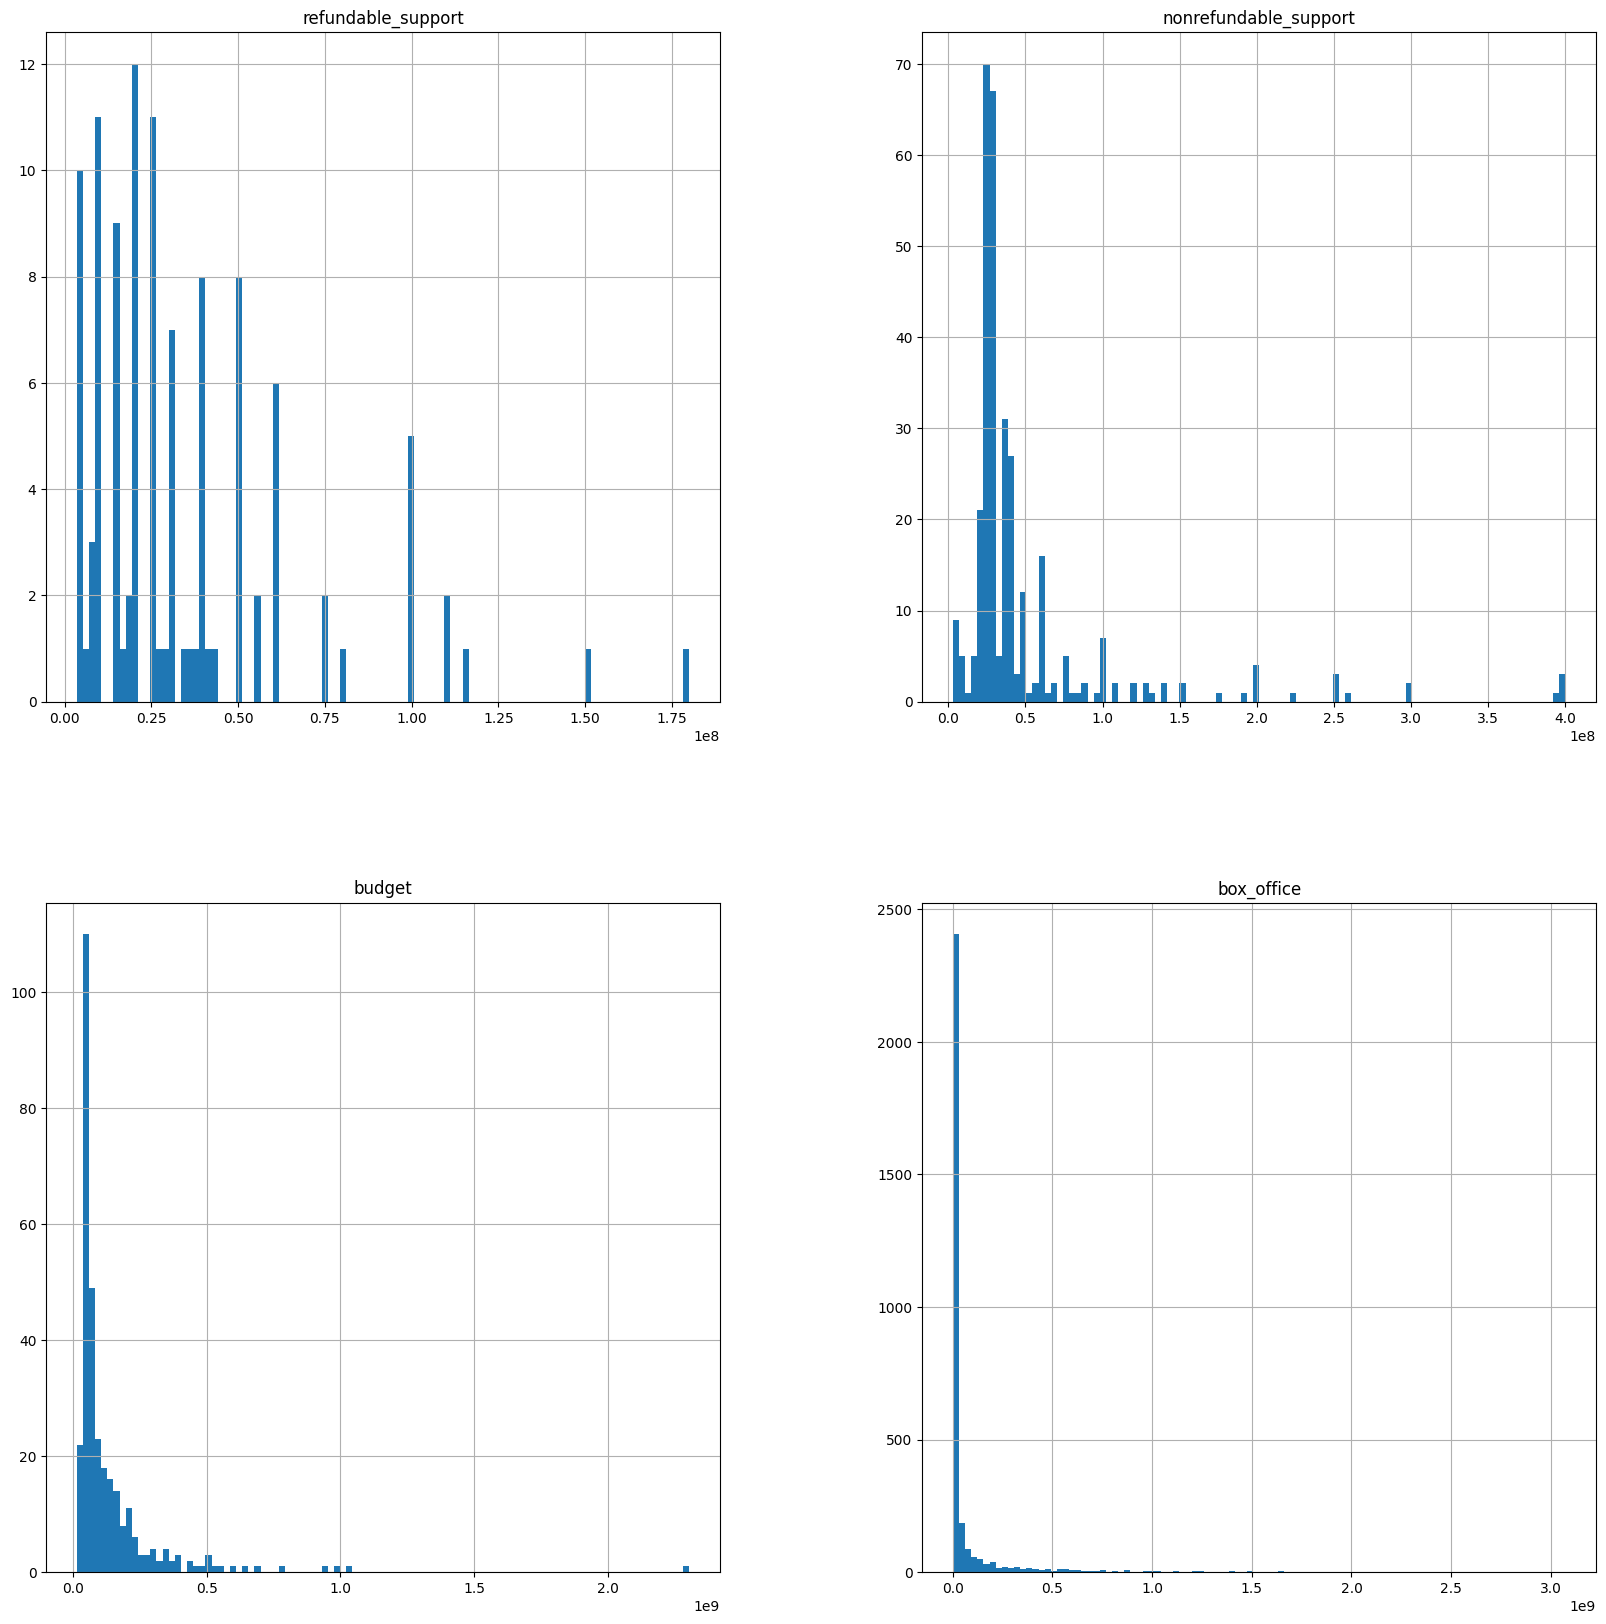

In [88]:
numeric = df.select_dtypes(include=['float', 'int'])
numeric.hist(bins=100, figsize=(20, 20));

Наблюдаем финансовую статистику с длинными хвостами. Учитывая цели исследования по нахождению трендов заметим, что выбросами можно считать значения более 125_000_000 для `refundable_support`, 16

Проанализировав на Яндекс.Картах эти 2 сочетания приходим к выводу, что это разные населённые пункты. Далее найдём сочетания с расстоянием Левенштайна равным 2.

In [44]:
print_duplicates(unique_names, 2)

NameError: name 'unique_names' is not defined

Все сочетания выглядят как уникальные населённые пункты. На всякий случай проверим сочетания с расстоянием Левенштайна в 3.

In [ ]:
print_duplicates(unique_names, 3)

Делаем вывод, что дубликатов в названиях населённых пунктов больше нет.

### Добавьте в таблицу новые столбцы

Добавим поле с ценой за квадратный метр.

In [ ]:
df["square_price"] = (df["last_price"] / df["total_area"]).round(2)
df["square_price"]

Добавим номер дня недели.

In [ ]:
df["day_index"] = df["first_day_exposition"].dt.weekday
df["day_index"]

Добавим номер месяца в году.

In [ ]:
df["month_index"] = df["first_day_exposition"].dt.month
df["month_index"]

Добавим номер года.

In [ ]:
df["year_index"] = df["first_day_exposition"].dt.year
df["year_index"]

Добавим тип этажа квартиры: «первый», «последний», «другой».

In [ ]:
def floor_type(df):
    if df["floor"] == 1:
        return "первый"
    elif df["floor"] == df["floors_total"]:
        return "последний"
    else:
        return "другой"

df["floor_type"] = df.apply(floor_type, axis=1)
df["floor_type"].nunique()

Добавим расстояние до центра города в километрах.

In [ ]:
df["city_center_km"] = (df["cityCenters_nearest"] / 1000).round().astype("Int64")
df["city_center_km"]

### Проведите исследовательский анализ данных

Перед отсечением выбросов сохраним количество записей в наборе данных чтобы получить в конце информацию о потерях в количестве записей после чистки.

In [ ]:
rows_before_purge = len(df)

Исследуем гистограмму распреденения площади недвижимости `total_area`.

In [ ]:
plt.hist(df["total_area"], bins=100);

Частотность недвижимости с большими значениями площади низкая. Т.к. предыдущий график не показывает явно выбросы, рассмотрим его же в логарифмическом масштабе.

In [ ]:
plt.hist(df["total_area"], bins=100, log=True);

Исходя из непрерывности значений площади делаем вывод, что большие значения площади больше 500 метров можно считать выбросами. Посчитаем их количество и выбросим из набора данных если их более чем на два порядка меньше, чем количества записей.

In [ ]:
print(f"Выбросов по общей площади в процентах: {100 * len(df[df['total_area'] > 400]['total_area']) / len(df):.2f}%")

In [ ]:
df = df[df['total_area'] <= 400]

Повторим предыдущий процесс для жилой площади `living_area`.

In [ ]:
plt.hist(df["living_area"], bins=100);

In [ ]:
plt.hist(df["living_area"], bins=100, log=True);

Учитывая распределения в обычном и логарифмическом масштабе, предположим, что выбросами можно считать значения большие 175 метров. Проверим это посчитав, сколько таких значений в выборке.

In [ ]:
print(f"Выбросов по жилой площади в процентах: {100 * len(df[df['living_area'] > 175]['living_area']) / len(df):.2f}%")

In [ ]:
df = df[df['living_area'] <= 175]

Повторим предыдущий процесс для кухонной площади `kitchen_area`.

In [ ]:
plt.hist(df["kitchen_area"], bins=100);

In [ ]:
plt.hist(df["kitchen_area"], bins=100, log=True);

Учитывая распределения в обычном и логарифмическом масштабе, предположим, что выбросами можно считать значения большие 50 метров. Проверим это посчитав, сколько таких значений в выборке.

In [ ]:
print(f"Выбросов по площади кухни в процентах: {100 * len(df[df['kitchen_area'] > 50]['kitchen_area']) / len(df):.2f}%")

In [ ]:
df = df[df['kitchen_area'] <= 50]

Рассмотрим рассперделдение цен на недвижимость `last_price`.

In [ ]:
plt.hist(df["last_price"], bins=100);

In [ ]:
plt.hist(df["last_price"], bins=100, log=True);

Предположим по обоим графикам распределения, что цены более 30 миллионов встречаются редко. Проверим это предположение.

In [ ]:
print(f"Выбросов по цене недвижимости в процентах: {100 * len(df[df['last_price'] > 30_000_000]['last_price']) / len(df):.2f}%")

Т.к. цена является целевым показателем, не спешим принимать решения и расмотрим boxplot для этого атрибута данных.

In [ ]:
plt.boxplot(df['last_price']);

Явно видно, что значения больше 150_000_000 можно считать выбросами. Обрежим выбросы более 150_000_000 по цене и посмотрим на boxplot ещё раз.

In [ ]:
plt.boxplot(df[df['last_price'] <= 150_000_000]['last_price']);

На этом графике видно явно, что реже встречаются цены более 100_000_000. Посмотрим, сколько таких объявлений.

In [ ]:
print(f"Выбросов по цене недвижимости в процентах: {100 * len(df[df['last_price'] > 100_000_000]['last_price']) / len(df):.2f}%")

Остановимся на том, что выбросами будем считать цены большие чем 100_000_000 и удалим такие значения из выорки.

In [ ]:
df = df[df['last_price'] <= 100_000_000]

Рассмотрим рассперделдение объявлений по количеству комнат `rooms`.

In [ ]:
plt.hist(df["rooms"], bins=100);

На графике явно видно, что относительно редко встречаются квартиры более чем с шестью комнатами. Проверим, сколько таких квартир в объявлениях.

In [ ]:
print(f"Выбросы по количеству комнат в процентах: {100 * len(df[df['rooms'] > 6]['rooms']) / len(df):.2f}%")

Таких значений мало, будем считать все объявления с количеством комнат более 6 выбросами и исключим их.

In [ ]:
df = df[df['rooms'] <= 6]

Рассмотрим рассперделдение высоты потолков `ceiling_height`.

In [ ]:
plt.hist(df["ceiling_height"], bins=100);

In [ ]:
plt.hist(df["ceiling_height"], bins=100, log=True);

Значений не очень много, поэтому изучим их частотность аналитически.

In [ ]:
df["ceiling_height"].value_counts()

Всё же значений достаточно много, что не было отражено на первом графике. Рассмотрим boxplot чтобы лучше понять распеределение.

In [ ]:
plt.boxplot(df["ceiling_height"]);

Предположим, что значения от 10 до 40 метров записаны как целочисленные, но их размерность в 10 раз ниже и фактически это не целочисленные значения. Преобразуем эти значения и удалим выброс в районе 100 метров.

In [ ]:
df = df[df['ceiling_height'] <= 40]
df = df.reset_index(drop=True)

In [ ]:
height_subset = df[df["ceiling_height"] > 10]
df["ceiling_height"] = pd.concat([
            df.iloc[df.index.difference(height_subset.index)]["ceiling_height"], 
            height_subset["ceiling_height"] / 10
        ])
df = df[df["ceiling_height"].notna()]
df = df.reset_index(drop=True)

In [ ]:
plt.hist(df["ceiling_height"], bins=100, log=True);

Теперь значения высоты потолков выглядят более правдоподобно, если допустить наличие коммерческой недвижимости в выборке.

Рассмотрим рассперделдение типов этажей `floor_type`.

In [ ]:
plt.hist(df["floor_type"], bins=100);

Большинство квартир ожидаемо находятся между первым и последним этажами.

Рассмотрим рассперделдение высоты зданий, в которых продаётся недвижимость `floors_total`.

In [ ]:
plt.hist(df["floors_total"], bins=100);

Заметим, что больше всего квартир в домах ниже 10 этажей, но много и домов выше в объявленях.

Рассмотрим рассперделдение расстояний до центра города `cityCenters_nearest`.

In [ ]:
plt.hist(df["cityCenters_nearest"], bins=100);

Большинство недвижимости продаётся примерно в 15 киломах от центра города. При этом есть малая часть объявлений, расположенных на расстоянии около 50 км от центра. Учитывая наличие различных населённых пунктов в выборке и единственный центр города - центр Санкт-Петербугра, делаем вывод, что это не выбросы, а особенность данных.

Рассмотрим рассперделдение до ближайшего парка `parks_nearest`.

In [ ]:
plt.hist(df["parks_nearest"], bins=100);

Распределение имеет длинных хвост схожий с наличием выбросов после 1500 метров. Проверим, какая часть данных сильно выделяется.

In [ ]:
print(f"Выбросы по расстоянию до парка в процентах: {100 * len(df[df['parks_nearest'] > 1500]['parks_nearest']) / len(df):.2f}%")

Учитывая количество значений расстояния до парка более 1.5 километров будем считать подобные расстояния выбросами и избавимся от них.

In [ ]:
df = df[df['parks_nearest'] <= 1500]

Проанализируем, насколько много данных потеряно после отсечения выбросов в основных атрибутах выборки.

In [ ]:
print(f"Процент утраченных после чистки записей: {100 - 100 * len(df) / rows_before_purge:.2f}%")

Количество потерь невелико, а качество данных улучшилось засчёт устранения выбросов.

Изучим скорость продажи недвижимости.

In [ ]:
df["days_exposition"].hist(bins=100);

Напоминает распределение Пуассона. Проанализируем описательную статистику: в частности среднее и медиану.

In [ ]:
df["days_exposition"].describe()

Делаем вывод, что "обычное" время ожидания продажи после размещения объявления это около 3 месяцев. Быстрой продажей можно считать подажи быстрее 2 месяцев. При этом в редких случаях время ожидания доходит и до нескольких лет.

Рассмотрим подробнее, как распределены значения от 0 до 100 дней.

In [ ]:
df[df["days_exposition"] <= 100]["days_exposition"].hist(bins=100);

Наблюдаем явные пики на 45 и 60 днях соответственно. Наибольший пик чере 1.5 месяца, вероятно, связан с обновлением статуса на платформе публицакации. Можно предположить, что в бесплатном тарифе этой платформы возможно поднятие объявления через 1.5 месяца.

Изучим влияние основных, на наш взгляд, характеристик, определяющих стоимость на неё же.

In [ ]:
features_subset = df[["last_price", "total_area", "living_area", "kitchen_area", "rooms"]]
sb.heatmap(features_subset.corr())

И рассмотрим влияние на цену этих атрибутов данных аналитически, отсортировав корреляции по убыванию.

In [ ]:
features_subset.corr().sort_values(by="last_price", ascending=False)["last_price"]

Для категориальных параметров построим гистограммы.

Начнём с этажей.

In [ ]:
df["floor"].hist(bins=50);

Для более подробного анализа построим столбчатую диаграмму по типам этажей к медианной цене продажи.

In [ ]:
df.pivot_table(index="floor_type", values="last_price", aggfunc=["median"]).plot.bar(xlabel="Тип этажа", ylabel="Медианная цена продажи");

Видим, что больше всего квартир продаётся на 2 этаже. Также заметно, что большинство недвижимости продаётся в пятиэтажных зданиях и что на первом этаже продажи происходят по меньшей цене, чем на последнем.

Рассмотрим категориальные данные о времени продажи.

In [ ]:
df["day_index"].hist(bins=50);

Для более подробного анализа построим столбчатую диаграмму по дням недели к цене продажи.

In [ ]:
df.pivot_table(index="day_index", values="last_price", aggfunc=["median"]).plot.bar(xlabel="День недели", ylabel="Медианная цена продажи");

Недвидимость активнее всего продают в рабочие дни в середине недели. Цена продажи мало зависит от дня недели, в который подали объявление.

In [ ]:
df["month_index"].hist(bins=50);

Для более подробного анализа построим столбчатую диаграмму по месяцам к цене продажи.

In [ ]:
df.pivot_table(index="month_index", values="last_price", aggfunc=["median"]).plot.bar(xlabel="Месяц", ylabel="Медианная цена продажи");

По времени года заметно, что активнее всего объявления о продаже недвижимости публикуют в холодную пору года. Исключение составляют новогодние каникулы и весенние праздники. Цена продажи наибольшая у объявлений, которые публикуют в декабре, сентябре и июле.

In [ ]:
df["year_index"].hist(bins=50);

Для более подробного анализа построим столбчатую диаграмму по типам этажей к цене продажи.

In [ ]:
df.pivot_table(index="year_index", values="last_price", aggfunc=["median"]).plot.bar(xlabel="Год", ylabel="Медианная цена продажи");

Можно сделать вывод, что наибольшее количество объявлений о продажах на этой платформе размещалось в 2017 году. После 2017 года начался постепенный спад, который резко увеличился к 2019 году. При этом медианная цена продажи падала до 2017 года и медленна начала расти к 2019.

Можно сделать вывод, что основными характеристиками данных, влияющими на цену, являются характеристики площади и количества комнат. При этом дата размещения объявления практически не влияет на цену продажи. Незначительно влияют этаж недвижимости и год продажи. 

Рассмотрим характеристики, влияющие на цену существенно, подробнее. Для этого изучим диаграммы рассеяния.

Начнём с общей площади нежвижимости.

In [ ]:
sb.scatterplot(df=features_subset, x="total_area", y="last_price", label="Общая площадь к цене", alpha=.1);

Прослеживается линейная зависимость между ценой и площадью для недвижимости с ценой продажи ниже 20_000_000 и общей площадью менее 150 квадратных метров.

Далее рассмотрим жилую площадь нежвижимости.

In [ ]:
sb.scatterplot(df=features_subset, x="living_area", y="last_price", label="Жилая площадь к цене", alpha=.1);

Для жилой площади линейность в зависимости с ценой прослеживается более явно и сильно искажается при цене более 20_000_000.

Рассмотрим площадь кухни с влиянием на цену.

In [ ]:
sb.scatterplot(df=features_subset, x="kitchen_area", y="last_price", label="Площадь кухни к цене", alpha=.1);

На графике прослеживается дискретность в площади кухонь. Так же явно видна линейная зависимость при цене ниже 20_000_000

Посмотрим на связь между количеством комнат и ценой.

In [ ]:
sb.scatterplot(df=features_subset, x="rooms", y="last_price", label="Количество комнат к цене", alpha=.1);

Характер зависимости больше напоминает кривую. При этом больше всего ценится недвижимость с 3 комнатами. Ценность растёт при возрастании количества от 1 к 3 комнатам и потом постепенно, медленнее чем росла, падает, для недвижимости с 6 комнатами. При этом для недвижимости с ценами более 40_000_000 количество комнат более двух слабо определяет цену.

Рассмострим обще цены на недвижимость в населённых пунктах региона.

In [ ]:
top10_locations_prices = df.pivot_table(index="locality_name", values="square_price", aggfunc=["count", "mean"])
top10_locations_prices.columns = ["count", "mean"]
top10_locations_prices = top10_locations_prices.sort_values(by="count", ascending=False).iloc[:10].sort_values(by="mean", ascending=False)
top10_locations_prices["mean"].plot(grid=True);

Как и ожидалось, цена Питерский недвижимости наиболее дорогая в регионе. Самая дешёвая недвижимость в Ленинградской области, если ограничиться 10 населёнными пунктами, в Выборге.

Теперь рассмотрим, как цена недвижимости меняется в Санкт-Петербурге в зависимости от удалённости от центра города.

In [ ]:
spb_centered_price = df[df["locality_name"] == "Санкт-Петербург"].pivot_table(index="city_center_km", values="square_price", aggfunc="mean")

plt.plot(spb_centered_price)
plt.xlabel("City center distance")
plt.ylabel("Square meter price")
plt.grid()

Как и предполагалось, цена метра в центре города наиболее высока и постепенно падает в зависимости от удаления от центра. Интересно заметить, что на 6-7, 19-20 и 27 километрах цена возрастает. В случае с 6-7 и 27 километрами рост весьма резкий.

### Напишите общий вывод

В исследовании была произведена подготовка данных:
 - подробное изучение зависимостей между данными
 - анализ и заполнение пропусков в данных
 - устранение дубликатов

После для удобства были созданы синтетические атрибуты данных.

Подробно ознакомились с основными характеристиками, влияющими на целевой показатель - цену.

Анализ основных характеристик показал, что:
 - выявлена **линейная зависимость** между **ценой** и **общей площадью** для недвижимости с ценой продажи ниже 20_000_000 и общей площадью менее 150 квадратных метров
 - выявлена **линейность** в зависимости **жилой площади** с **ценой**, которая **искажается** при **цене более 20_000_000**
 - выявлена **линейнай зависимость** **площади кухни** от **цены** при цене ниже 20_000_000
 - выявлен **нелинейный** тип **зависимости** **цены** от **количества комнат**. Ценность **растёт** при возрастании количества **от 1 к 3 комнатам** и потом постепенно, медленнее чем росла, **падает** для недвижимости **с 6 комнатами**. При этом для недвижимости с **ценами более 40_000_000 количество комнат** более двух **слабо определяет цену**.
 - **больше** всего недвижимости продаётся **на втором этаже**. **Больше** всего **зданий**, в которых продаётся недвижимость, **пятиэтажные**. **Дороже** всего недвижимость продаётся **в середине здания** и **дешевле** всего **на первом этаже**.
 - Новые объявления в основном **публикуются** в **рабочие дни** ближе к **середине** рабочей **недели** и **цена продажи** почти **не зависит** от **дня публикации** объявления. 
 - **Чаще** публикуются новые объявления **в холодную пору года** с исключениями во время новогодных и весенних каникул. **Цена** продажи **наибольшая** у объявлений, которые **публикуют** в **декабре, сентябре и июле**.
 - Количество объявлений плавно **росло с 2014 до 2017 года** и **резко сократилось** после плато 2018 года в **2019** году. При этом медианная **цена** продажи **падала до 2017** года и медленна **начала расти к 2019**. 

Были выявлены населённые пункты с **наибольшей** и **наименьшей ценой** нежвижимости: **Санкт-Петербург** и **Выборг**, соответственно.

Построен наглядный график изменения цены квадратного метра.

**Цена метра** в центре города наиболее высокая и постепенно **убывает** в зависимости от удаления **от центра**. На 6-7 километрах, 19-20 и 27 километрах **цена локально теряет монотонность**. В случае с 6-7 и 27 километрами изменения весьма резкие.